In [34]:
import xml.etree.ElementTree as ET
import xml
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import IPython
import os
import json
import random
import numpy as np
import requests
from io import BytesIO
import base64
from math import trunc
from PIL import Image as PILImage
from PIL import ImageDraw as PILImageDraw
from pathlib import Path
from tqdm import tqdm
import shutil
import numpy as np
import torch
from PIL import Image, ImageDraw, ImageFont

import torch

import groundingdino.datasets.transforms as T
from groundingdino.models import build_model
from groundingdino.util import box_ops
from groundingdino.util.slconfig import SLConfig
from groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from groundingdino.util.vl_utils import create_positive_map_from_span

In [36]:
def image_element_to_image_data(e: xml.etree.ElementTree.Element) -> dict:
    boxes = e.findall('box')
    boxes_data = []

    def to_xy(e) -> dict:
        return {'x': int(e.get('x')), 'y': int(e.get('y'))}
        
    for box in boxes:
        htop = [p for p in box.findall('part') if p.get('name') == 'htop'][0]
        lear = [p for p in box.findall('part') if p.get('name') == 'lear'][0]
        rear = [p for p in box.findall('part') if p.get('name') == 'rear'][0]
        nose = [p for p in box.findall('part') if p.get('name') == 'nose'][0]
        leye = [p for p in box.findall('part') if p.get('name') == 'leye'][0]
        reye = [p for p in box.findall('part') if p.get('name') == 'reye'][0]
        data = {
            "top": int(box.get("top")), 
            "left": int(box.get("left")), 
            "width": int(box.get("width")), 
            "height": int(box.get("height")),
            'parts': {
                'htop': to_xy(htop), 
                'lear': to_xy(lear), 
                'rear': to_xy(rear), 
                'nose': to_xy(nose), 
                'leye': to_xy(leye), 
                'reye': to_xy(reye)
            }
        }
        boxes_data.append(data)

    filepath = base_path / e.get("file")
    
    return {
        "filepath": filepath,
        "bboxes": boxes_data,
    }

def parse_xml(filepath: Path) -> dict:
    tree = ET.parse(label_path)
    root = tree.getroot()
    image_elements = root.find('images').findall('image')
    return {
        "images": [image_element_to_image_data(e) for e in image_elements],
    }

def load_xml(filepath: Path) -> dict:
    xml_data =  parse_xml(label_path)
    
    # Add image size to image_data
    for image_data in xml_data['images']:
        image = Image.open(image_data['filepath'])
        width, height = image.size
        image_data['size'] = {'width': width, 'height': height}
        
    return xml_data

In [61]:
def display_bbox(bbox, ax) -> None:
    
    # Ears
    ax.plot(bbox['parts']["lear"]["x"], bbox['parts']["lear"]["y"], marker='x', color="yellow") 
    ax.plot(bbox['parts']["rear"]["x"], bbox['parts']["rear"]["y"], marker='x', color="yellow")  

    # Head Top
    ax.plot(bbox['parts']["htop"]["x"], bbox['parts']["htop"]["y"], marker='v', color="white") 

    # Nose
    ax.plot(bbox['parts']["nose"]["x"], bbox['parts']["nose"]["y"], marker='o', color="green") 

    # Eyes
    ax.plot(bbox['parts']["leye"]["x"], bbox['parts']["leye"]["y"], marker='x', color="blue") 
    ax.plot(bbox['parts']["reye"]["x"], bbox['parts']["reye"]["y"], marker='x', color="blue")  

    rect = patches.Rectangle(
        (bbox['left'], bbox['top']),
        bbox['width'],
        bbox['height'],
        linewidth=2,
        edgecolor='r',
        facecolor='none'
    )

    ax.add_patch(rect)
    return ax

def load_image(image_path):
    # load image
    image_pil = Image.open(image_path).convert("RGB")  # load image

    transform = T.Compose(
        [
            T.RandomResize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    image, _ = transform(image_pil, None)  # 3, h, w
    return image_pil, image


def display_pred(pred_dict, ax):
    H, W = pred_dict["size"]
    boxes = pred_dict["boxes"]
    labels = pred_dict["labels"]
    assert len(boxes) == len(labels), "boxes and labels must have same length"

    # draw boxes and masks
    for i, (box, label) in enumerate(zip(boxes, labels)):
        # from 0..1 to 0..W, 0..H
        box = box * torch.Tensor([W, H, W, H])
        # from xywh to xyxy
        box[:2] -= box[2:] / 2
        box[2:] += box[:2]

        # draw
        x0, y0, x1, y1 = box
        x0, y0, x1, y1 = int(x0), int(y0), int(x1), int(y1)

        if i == 0 :
            edgecolor = 'w'
        else:
            edgecolor = 'y'
        
        rect = patches.Rectangle(
            (x0, y0),
            x1-x0,
            y1-y0,
            linewidth=2,
            edgecolor=edgecolor,
            facecolor='none'
        )
    
        ax.add_patch(rect)
    return ax

def display_image_data(image_data, img, pred_dict):
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    for bbox in image_data['bboxes']:
        display_bbox(bbox, ax)

    display_pred(pred_dict, ax)
    
    plt.show()

In [38]:
base_path = Path('../../data/01_raw/BearID/')
label_path = base_path / 'images_train_without_bc.xml'

In [39]:
xml_data = load_xml(label_path)

In [40]:
xml_data['images'][0]

{'filepath': PosixPath('../../data/01_raw/BearID/images/brooksFalls/je_201708/bf_755/755-scare-d-bear-near-the-north-side-of-brooks-falls_9237775339_o.jpg'),
 'bboxes': [{'top': 1059,
   'left': 1172,
   'width': 200,
   'height': 200,
   'parts': {'htop': {'x': 1283, 'y': 1068},
    'lear': {'x': 1335, 'y': 1080},
    'rear': {'x': 1228, 'y': 1084},
    'nose': {'x': 1279, 'y': 1197},
    'leye': {'x': 1324, 'y': 1132},
    'reye': {'x': 1246, 'y': 1133}}}],
 'size': {'width': 2000, 'height': 1500}}

In [41]:
def get_grounding_output(model, image, caption, box_threshold, text_threshold=None, with_logits=True, cpu_only=False, token_spans=None):
    assert text_threshold is not None or token_spans is not None, "text_threshould and token_spans should not be None at the same time!"
    caption = caption.lower()
    caption = caption.strip()
    if not caption.endswith("."):
        caption = caption + "."
    device = "mps" # "cuda" if not cpu_only else "cpu"
    model = model.to(device)
    image = image.to(device)
    with torch.no_grad():
        outputs = model(image[None], captions=[caption])
    logits = outputs["pred_logits"].sigmoid()[0]  # (nq, 256)
    boxes = outputs["pred_boxes"][0]  # (nq, 4)

    # filter output
    if token_spans is None:
        logits_filt = logits.cpu().clone()
        boxes_filt = boxes.cpu().clone()
        filt_mask = logits_filt.max(dim=1)[0] > box_threshold
        logits_filt = logits_filt[filt_mask]  # num_filt, 256
        boxes_filt = boxes_filt[filt_mask]  # num_filt, 4

        # get phrase
        tokenlizer = model.tokenizer
        tokenized = tokenlizer(caption)
        # build pred
        pred_phrases = []
        for logit, box in zip(logits_filt, boxes_filt):
            pred_phrase = get_phrases_from_posmap(logit > text_threshold, tokenized, tokenlizer)
            if with_logits:
                pred_phrases.append((pred_phrase, logit.max().item()))
            else:
                pred_phrases.append((pred_phrase,-1))
    else:
        # given-phrase mode
        positive_maps = create_positive_map_from_span(
            model.tokenizer(text_prompt),
            token_span=token_spans
        ).to(image.device) # n_phrase, 256

        logits_for_phrases = positive_maps @ logits.T # n_phrase, nq
        all_logits = []
        all_phrases = []
        all_boxes = []
        for (token_span, logit_phr) in zip(token_spans, logits_for_phrases):
            # get phrase
            phrase = ' '.join([caption[_s:_e] for (_s, _e) in token_span])
            # get mask
            filt_mask = logit_phr > box_threshold
            # filt box
            all_boxes.append(boxes[filt_mask])
            # filt logits
            all_logits.append(logit_phr[filt_mask])
            if with_logits:
                logit_phr_num = logit_phr[filt_mask]
                all_phrases.extend([(phrase, logit.item())] for logit in logit_phr_num)
            else:
                all_phrases.extend([(phrase, -1) for _ in range(len(filt_mask))])
        boxes_filt = torch.cat(all_boxes, dim=0).cpu()
        pred_phrases = all_phrases


    return boxes_filt, pred_phrases


In [46]:
model_config_path = "../../data/06_models/bearfacedetection/GroundingDINO/GroundingDINO_SwinT_OGC.py"
model_checkpoint_path = "../../data/06_models/bearfacedetection/GroundingDINO/groundingdino_swint_ogc.pth"

args = SLConfig.fromfile(model_config_path)
args.device = "mps" # "cuda", "mps" (for M1/M2) or "cpu"
model = build_model(args)
checkpoint = torch.load(model_checkpoint_path, map_location="cpu")
load_res = model.load_state_dict(clean_state_dict(checkpoint["model"]), strict=False)
print(load_res)
_ = model.eval()


final text_encoder_type: bert-base-uncased
_IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


In [59]:
text_prompt = "head of bear"
token_spans = [[(0,4)]]
# token_spans = None
box_threshold = 0.27
text_threshold = 0.25

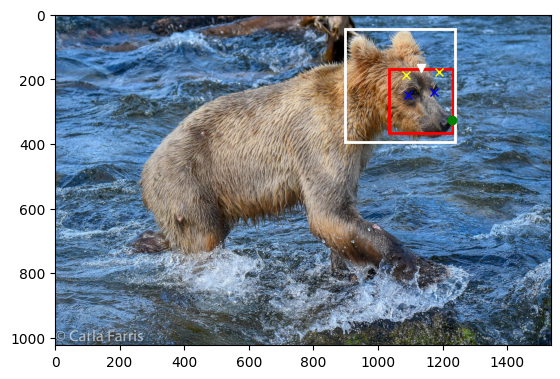

[[('head', 0.3317933976650238)]]


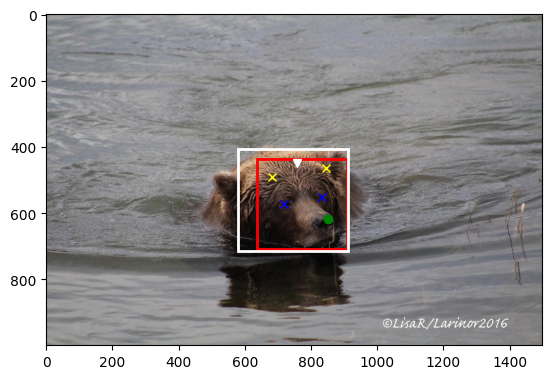

[[('head', 0.27082088589668274)]]


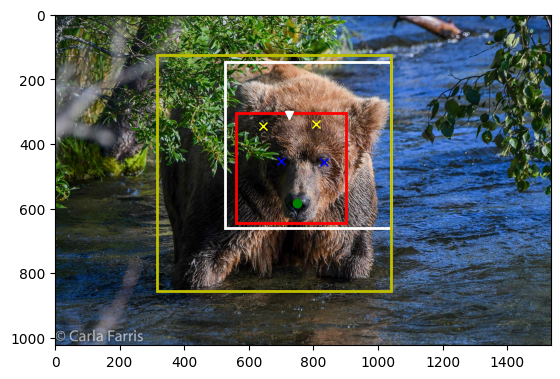

[[('head', 0.4130379259586334)], [('head', 0.30494165420532227)]]


In [63]:
random.seed(42)
N_samples = 3

for _ in range(N_samples):
    idx = random.randint(0, len(xml_data['images']))
    image_data = xml_data['images'][idx]
    
    image_pil, image = load_image(image_data['filepath'])

    boxes_filt, pred_phrases = get_grounding_output(
        model, image, text_prompt, box_threshold, text_threshold, cpu_only=False, token_spans=token_spans)
    
    size = image_pil.size
    pred_dict = {
        "boxes": boxes_filt,
        "size": [size[1], size[0]],  # H,W
        "labels": pred_phrases,
    }
    
    display_image_data(xml_data['images'][idx], image_pil, pred_dict)
    print(pred_phrases)